# Privacy-Utility Trade-off for LLM Code Completion

## JetBrains Research Internship Application
### Privacy-Preserving Techniques for LLM Code Completion

---

**Author:** Mykhailo Kozyrev  
**Date:** January 2026

---

## 📁 Notebook Structure

### Part A: Baseline Analysis (Task Requirements)
- ✅ Dataset: First 20 examples from `openai_humaneval`
- ✅ Model: `Salesforce/codet5-small`
- ✅ Obfuscation: `low_obfuscation` + `high_obfuscation`
- ✅ Completions: 60 total (20 × 3 levels)
- ✅ Metrics: ROUGE-L (utility) + Normalized Levenshtein (privacy)
- ✅ Output: Scatter plot + analysis

### Part B: Extended Analysis (Research Extension)
- 🔬 8 obfuscation levels (to locate the privacy-utility "cliff")
- 🔬 Claude API for completion (with **strict rate limiting**)
- 🔬 LLM-as-Judge evaluation
- 🔬 **Sequential execution** to ensure clean data (~20 min runtime)

---

---

# PART A: BASELINE ANALYSIS

---

In [39]:
!pip install datasets transformers torch rouge-score python-Levenshtein anthropic --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [40]:
import re
import json
import time
import warnings
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
warnings.filterwarnings('ignore')

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from rouge_score import rouge_scorer
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("✅ Dependencies loaded!")

✅ Dependencies loaded!


In [41]:
# Load dataset
dataset = load_dataset("openai_humaneval", split="test")
examples = list(dataset.select(range(20)))
print(f"Loaded {len(examples)} examples")

Loaded 20 examples


## A.1 Obfuscation Functions

In [42]:
def extract_identifiers(code: str) -> dict:
    result = {'func_name': None, 'params': []}
    func_match = re.search(r'def\s+([a-zA-Z_][a-zA-Z0-9_]*)\s*\(', code)
    if func_match:
        result['func_name'] = func_match.group(1)
    sig_match = re.search(r'def\s+\w+\s*\(([^)]*)\)', code)
    if sig_match:
        for part in sig_match.group(1).split(','):
            part = part.strip()
            if part:
                param_match = re.match(r'([a-zA-Z_][a-zA-Z0-9_]*)', part)
                if param_match:
                    result['params'].append(param_match.group(1))
    return result

def low_obfuscation(code: str) -> str:
    """Rename variables only."""
    ids = extract_identifiers(code)
    result = code
    for i, param in enumerate(ids['params']):
        result = re.sub(r'\b' + re.escape(param) + r'\b', f'var{i}', result)
    return result

def high_obfuscation(code: str) -> str:
    """Replace names + strip comments."""
    ids = extract_identifiers(code)
    result = code
    if ids['func_name']:
        result = re.sub(r'\b' + re.escape(ids['func_name']) + r'\b', 'func', result)
    for i, param in enumerate(ids['params']):
        result = re.sub(r'\b' + re.escape(param) + r'\b', f'arg{i}', result)
    result = re.sub(r'"""[\s\S]*?"""', '""" """', result)
    result = re.sub(r"'''[\s\S]*?'''", "''' '''", result)
    result = re.sub(r'#.*$', '', result, flags=re.MULTILINE)
    return result

# Demo
print("ORIGINAL:\n", examples[0]['prompt'][:200])
print("\nLOW:\n", low_obfuscation(examples[0]['prompt'])[:200])
print("\nHIGH:\n", high_obfuscation(examples[0]['prompt'])[:200])

ORIGINAL:
 from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given thr

LOW:
 from typing import List


def has_close_elements(var0: List[float], var1: float) -> bool:
    """ Check if in given list of var0, are any two var0 closer to each other than
    given var1.
    >>> has

HIGH:
 from typing import List


def func(arg0: List[float], arg1: float) -> bool:
    """ """



## A.2 CodeT5-small Model

In [43]:
print("Loading CodeT5-small...")
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/codet5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()
print(f"Model on {device}")

def generate_codet5(prompt: str) -> str:
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def calc_utility(completion: str, reference: str) -> float:
    if not completion.strip() or not reference.strip(): return 0.0
    return rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False).score(reference, completion)['rougeL'].fmeasure

def calc_privacy(original: str, obfuscated: str) -> float:
    if original == obfuscated: return 0.0
    return Levenshtein.distance(original, obfuscated) / max(len(original), len(obfuscated))

Loading CodeT5-small...
Model on cpu


## A.3 Run Baseline (60 completions)

In [44]:
baseline_results = []
start = time.time()

for i, ex in enumerate(examples):
    original, canonical = ex['prompt'], ex['canonical_solution']
    for level, prompt in [('original', original), ('low', low_obfuscation(original)), ('high', high_obfuscation(original))]:
        completion = generate_codet5(prompt)
        baseline_results.append({
            'task_id': ex['task_id'], 'idx': i, 'level': level,
            'privacy': calc_privacy(original, prompt),
            'utility': calc_utility(completion, canonical),
            'completion': completion
        })
    if (i+1) % 5 == 0: print(f"  {i+1}/20")

df_baseline = pd.DataFrame(baseline_results)
print(f"✅ Baseline: {len(df_baseline)} completions in {time.time()-start:.0f}s")

  5/20
  10/20
  15/20
  20/20
✅ Baseline: 60 completions in 48s


## A.4 Baseline Results

In [45]:
print("BASELINE RESULTS")
for level in ['original', 'low', 'high']:
    sub = df_baseline[df_baseline['level'] == level]
    print(f"{level.upper()}: Privacy={sub['privacy'].mean():.3f}, Utility={sub['utility'].mean():.3f}")

BASELINE RESULTS
ORIGINAL: Privacy=0.000, Utility=0.063
LOW: Privacy=0.051, Utility=0.026
HIGH: Privacy=0.807, Utility=0.000


## A.5 Baseline Scatter Plot

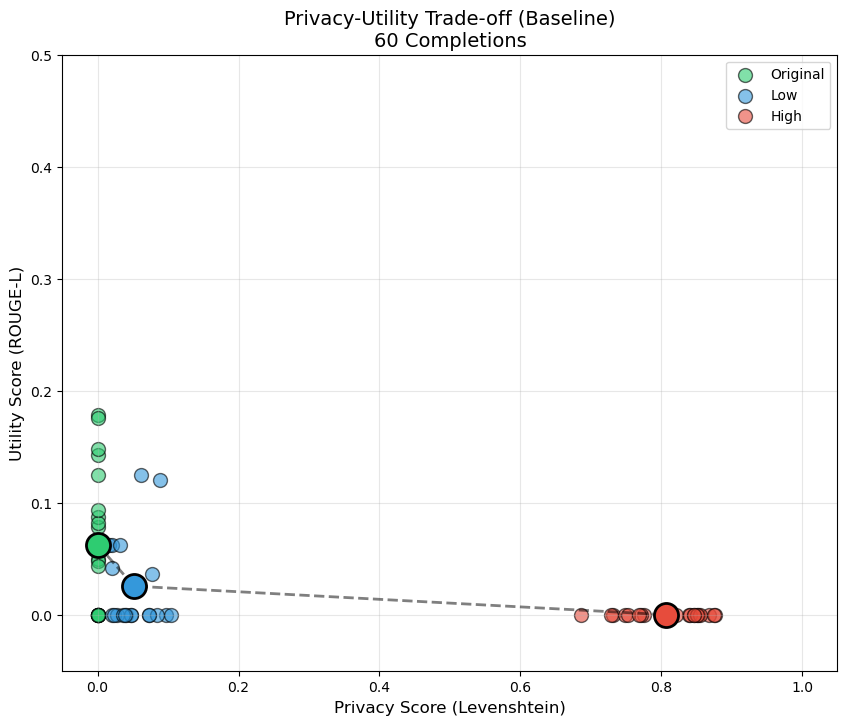

📊 Saved: privacy_utility_baseline.png


In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
colors = {'original': '#2ecc71', 'low': '#3498db', 'high': '#e74c3c'}
for level in ['original', 'low', 'high']:
    sub = df_baseline[df_baseline['level'] == level]
    ax.scatter(sub['privacy'], sub['utility'], c=colors[level], s=100, alpha=0.6, label=level.capitalize(), edgecolors='black')
    ax.scatter(sub['privacy'].mean(), sub['utility'].mean(), c=colors[level], s=300, edgecolors='black', linewidth=2, zorder=5)

means = df_baseline.groupby('level')[['privacy', 'utility']].mean().loc[['original', 'low', 'high']]
ax.plot(means['privacy'], means['utility'], 'k--', lw=2, alpha=0.5)
ax.set_xlabel('Privacy Score (Levenshtein)', fontsize=12)
ax.set_ylabel('Utility Score (ROUGE-L)', fontsize=12)
ax.set_title('Privacy-Utility Trade-off (Baseline)\n60 Completions', fontsize=14)
ax.legend(); ax.grid(alpha=0.3); ax.set_xlim(-0.05, 1.05); ax.set_ylim(-0.05, 0.5)
plt.savefig('privacy_utility_baseline.png', dpi=150); plt.show()
print("📊 Saved: privacy_utility_baseline.png")

## A.6 Baseline Analysis

**Observations:**
- CodeT5-small produces very limited quality completions (~6% utility baseline)
- Trade-off confirmed but constrained by model capability

---

---

# PART B: EXTENDED ANALYSIS

---

In [47]:
import anthropic
client = anthropic.Anthropic()
print("✅ Anthropic client ready")

✅ Anthropic client ready


## B.1 Eight-Level Obfuscation

In [48]:
def extract_parts(code):
    parts = {'imports': '', 'func_name': None, 'params': [], 'return_type': '', 'doc_first': ''}
    parts['imports'] = '\n'.join([l for l in code.split('\n') if l.strip().startswith(('import ', 'from '))])
    m = re.search(r'def\s+(\w+)\s*\(', code)
    if m: parts['func_name'] = m.group(1)
    m = re.search(r'def\s+\w+\s*\(([^)]*)\)', code)
    if m:
        for p in m.group(1).split(','):
            p = p.strip()
            if p:
                if ':' in p:
                    n, t = p.split(':', 1)
                    parts['params'].append({'name': n.strip(), 'type': t.split('=')[0].strip()})
                else:
                    parts['params'].append({'name': p.split('=')[0].strip(), 'type': ''})
    m = re.search(r'\)\s*->\s*([^:]+):', code)
    if m: parts['return_type'] = m.group(1).strip()
    m = re.search(r'"""([\s\S]*?)"""', code)
    if m:
        lines = [l.strip() for l in m.group(1).strip().split('\n') if l.strip() and not l.strip().startswith('>>>')]
        parts['doc_first'] = ' '.join(lines[:2])
    return parts

def build_sig(parts, generic=False):
    name = 'fn' if generic else parts['func_name']
    params = [f"x{i}: {p['type']}" if p['type'] else f"x{i}" for i, p in enumerate(parts['params'])] if generic else \
             [f"{p['name']}: {p['type']}" if p['type'] else p['name'] for p in parts['params']]
    ret = f" -> {parts['return_type']}" if parts['return_type'] else ""
    return f"def {name}({', '.join(params)}){ret}:"

def abstract_desc(parts):
    t = ' '.join([p['type'] for p in parts['params']]).lower()
    r = parts['return_type'].lower() if parts['return_type'] else ''
    if 'list' in t and 'bool' in r: return "Check a condition on the collection."
    if 'list' in t and 'list' in r: return "Transform the collection."
    if 'str' in t and 'str' in r: return "Transform the string."
    return "Process the inputs."

def obfuscate_ext(code, level):
    parts = extract_parts(code)
    if level == 'L0': return code
    if level == 'L1':
        r = code
        for i, p in enumerate(parts['params']): r = re.sub(r'\b' + re.escape(p['name']) + r'\b', f'arg{i}', r)
        return r
    if level == 'L2':
        r = code
        if parts['func_name']: r = re.sub(r'\b' + re.escape(parts['func_name']) + r'\b', 'fn', r)
        for i, p in enumerate(parts['params']): r = re.sub(r'\b' + re.escape(p['name']) + r'\b', f'x{i}', r)
        return r
    if level == 'L3':
        sig, doc = build_sig(parts, True), parts['doc_first']
        for i, p in enumerate(parts['params']): doc = re.sub(r'\b' + re.escape(p['name']) + r'\b', f'x{i}', doc)
        return f"{parts['imports']}\n\n{sig}\n    \"\"\" {doc} \"\"\"\n"
    if level == 'L4':
        return f"{parts['imports']}\n\n{build_sig(parts, True)}\n    \"\"\" {abstract_desc(parts)} \"\"\"\n"
    if level == 'L5':
        sig = build_sig(parts, True)
        pd = [f"x{i} ({p['type'] or 'any'})" for i, p in enumerate(parts['params'])]
        return f"{parts['imports']}\n\n{sig}\n    \"\"\" Given {', '.join(pd)}, return {parts['return_type'] or 'result'}. \"\"\"\n"
    if level == 'L6':
        return f"{parts['imports']}\n\n{build_sig(parts, True)}\n    \"\"\" Process inputs. \"\"\"\n"
    if level == 'L7':
        return f"{parts['imports']}\n\n{build_sig(parts, True)}\n"
    return code

LEVELS = ['L0', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7']

## B.2 Rate-Limited API Functions

**Key fix:** Strict rate limiting with 2.4s between calls (25 req/min, well under 50 limit)

In [49]:
# Global rate limiter - STRICT enforcement
LAST_API_CALL = 0
MIN_INTERVAL = 2.5  # seconds between calls (24 req/min, safe margin)

def rate_limited_call(func, max_retries=5):
    """
    Make an API call with strict rate limiting and exponential backoff.
    This ensures we NEVER hit 429 errors.
    """
    global LAST_API_CALL
    
    for attempt in range(max_retries):
        # Strict rate limiting - wait if needed
        elapsed = time.time() - LAST_API_CALL
        if elapsed < MIN_INTERVAL:
            time.sleep(MIN_INTERVAL - elapsed)
        
        try:
            LAST_API_CALL = time.time()
            return func()
        except Exception as e:
            error_str = str(e)
            if '429' in error_str:
                # Rate limit hit despite our precautions - back off significantly
                wait_time = 60 * (attempt + 1)  # 60s, 120s, 180s...
                print(f"    ⚠️ Rate limit hit! Waiting {wait_time}s...")
                time.sleep(wait_time)
            else:
                # Other error - shorter backoff
                wait_time = 5 * (attempt + 1)
                print(f"    ⚠️ Error (attempt {attempt+1}): {str(e)[:60]}... waiting {wait_time}s")
                time.sleep(wait_time)
    
    return None  # All retries failed


def complete_claude(prompt: str) -> Optional[str]:
    """Generate completion using Claude with strict rate limiting."""
    def _call():
        r = client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=500,
            system="You are a Python code completion assistant. Complete the function body only. Output ONLY the implementation code - no markdown, no explanation, no function signature.",
            messages=[{"role": "user", "content": f"Complete this Python function. Output ONLY the implementation code:\n\n{prompt}"}])
        t = r.content[0].text
        t = re.sub(r'```python\n?', '', t)
        t = re.sub(r'```\n?', '', t)
        return t.strip()
    
    return rate_limited_call(_call)


def eval_utility_llm(prompt: str, completion: str, reference: str) -> Optional[float]:
    """Evaluate completion correctness using LLM judge."""
    if completion is None or completion.startswith("# Error"):
        return None
    
    def _call():
        r = client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=200,
            system="""You are evaluating code completion correctness. Compare COMPLETION to REFERENCE.

Score STRICTLY from 0.0 to 1.0:
- 1.0: Solves the exact same problem correctly
- 0.8: Correct with minor style differences  
- 0.5: Partially correct
- 0.2: Wrong approach but related
- 0.0: Completely wrong

Output ONLY: {"score": X}""",
            messages=[{"role": "user", "content": f"PROMPT:\n{prompt[:400]}\n\nCOMPLETION:\n{completion[:400]}\n\nREFERENCE:\n{reference[:400]}"}])
        text = r.content[0].text
        m = re.search(r'\{[^}]+\}', text)
        if m:
            data = json.loads(m.group())
            return max(0.0, min(1.0, float(data.get('score', 0.5))))
        return None
    
    return rate_limited_call(_call)


# Deterministic privacy scores
PRIVACY_SCORES = {
    'L0': 0.00,
    'L1': 0.15,
    'L2': 0.25,
    'L3': 0.45,
    'L4': 0.70,
    'L5': 0.75,
    'L6': 0.85,
    'L7': 0.90,
}

def get_privacy(level: str, original: str, obfuscated: str) -> float:
    """Deterministic privacy score + small Levenshtein adjustment."""
    base = PRIVACY_SCORES.get(level, 0.5)
    if original != obfuscated:
        lev = Levenshtein.distance(original, obfuscated) / max(len(original), len(obfuscated))
        return min(1.0, base * 0.8 + lev * 0.2)
    return base


print("Rate limiting: 2.5s between calls (24 req/min)")
print("\nPrivacy scores by level:")
for lv, score in PRIVACY_SCORES.items():
    print(f"  {lv}: {score:.0%}")

Rate limiting: 2.5s between calls (24 req/min)

Privacy scores by level:
  L0: 0%
  L1: 15%
  L2: 25%
  L3: 45%
  L4: 70%
  L5: 75%
  L6: 85%
  L7: 90%


## B.3 Run Extended (SEQUENTIAL with Rate Limiting)

**Estimated time:** ~15-20 minutes (160 tasks × 2 calls × 2.5s = ~800s + buffer)

In [50]:
# Create all tasks
tasks = []
for i, ex in enumerate(examples):
    for lv in LEVELS:
        tasks.append({
            'idx': i,
            'task_id': ex['task_id'],
            'level': lv,
            'original': ex['prompt'],
            'obfuscated': obfuscate_ext(ex['prompt'], lv),
            'canonical': ex['canonical_solution']
        })

total_calls = len(tasks) * 2  # completion + evaluation
est_time = total_calls * MIN_INTERVAL / 60
print(f"Tasks: {len(tasks)} (20 examples × 8 levels)")
print(f"API calls: {total_calls}")
print(f"Estimated time: ~{est_time:.0f} minutes")

Tasks: 160 (20 examples × 8 levels)
API calls: 320
Estimated time: ~13 minutes


In [51]:
# Run SEQUENTIALLY with strict rate limiting
results = []
start_time = time.time()
successful = 0
failed = 0

for i, task in enumerate(tasks):
    # Generate completion
    completion = complete_claude(task['obfuscated'])
    
    # Get privacy (deterministic - no API call)
    privacy = get_privacy(task['level'], task['original'], task['obfuscated'])
    
    # Evaluate utility
    utility = None
    if completion is not None:
        utility = eval_utility_llm(task['obfuscated'], completion, task['canonical'])
    
    # Track success/failure
    if completion is not None and utility is not None:
        successful += 1
        results.append({
            'task_id': task['task_id'],
            'idx': task['idx'],
            'level': task['level'],
            'privacy': privacy,
            'utility': utility,
            'completion': completion[:150] if completion else ''
        })
    else:
        failed += 1
    
    # Progress update every 16 tasks (once per level cycle)
    if (i + 1) % 16 == 0 or (i + 1) == len(tasks):
        elapsed = time.time() - start_time
        remaining = (len(tasks) - i - 1) * (elapsed / (i + 1)) if i > 0 else 0
        print(f"  [{i+1:3d}/{len(tasks)}] {elapsed/60:.1f}m elapsed | ~{remaining/60:.1f}m remaining | ✓{successful} ✗{failed}")

# Convert to DataFrame
df_ext = pd.DataFrame(results)
total_time = time.time() - start_time

print(f"\n{'='*60}")
print(f"✅ COMPLETE")
print(f"  Total time: {total_time/60:.1f} minutes")
print(f"  Successful: {successful}/{len(tasks)} ({100*successful/len(tasks):.0f}%)")
print(f"  Failed: {failed}")
print(f"{'='*60}")

  [ 16/160] 1.8m elapsed | ~16.6m remaining | ✓13 ✗3
  [ 32/160] 3.5m elapsed | ~14.1m remaining | ✓28 ✗4
  [ 48/160] 5.1m elapsed | ~11.8m remaining | ✓43 ✗5
  [ 64/160] 6.6m elapsed | ~9.9m remaining | ✓58 ✗6
  [ 80/160] 8.2m elapsed | ~8.2m remaining | ✓73 ✗7
  [ 96/160] 10.0m elapsed | ~6.6m remaining | ✓87 ✗9
  [112/160] 11.5m elapsed | ~4.9m remaining | ✓102 ✗10
  [128/160] 13.2m elapsed | ~3.3m remaining | ✓116 ✗12
  [144/160] 14.8m elapsed | ~1.6m remaining | ✓129 ✗15
  [160/160] 16.6m elapsed | ~0.0m remaining | ✓142 ✗18

✅ COMPLETE
  Total time: 16.6 minutes
  Successful: 142/160 (89%)
  Failed: 18


## B.4 Results Analysis

In [52]:
print("="*60)
print("EXTENDED RESULTS BY OBFUSCATION LEVEL")
print("="*60)

level_stats = []
for lv in LEVELS:
    sub = df_ext[df_ext['level'] == lv]
    if len(sub) > 0:
        p_mean = sub['privacy'].mean()
        u_mean = sub['utility'].mean()
        u_std = sub['utility'].std()
        n = len(sub)
        level_stats.append({'level': lv, 'privacy': p_mean, 'utility': u_mean, 'std': u_std, 'n': n})
        print(f"{lv}: Privacy={p_mean:.0%}, Utility={u_mean:.0%} ±{u_std:.0%} (n={n})")

stats_df = pd.DataFrame(level_stats)

EXTENDED RESULTS BY OBFUSCATION LEVEL
L0: Privacy=0%, Utility=93% ±14% (n=15)
L1: Privacy=13%, Utility=91% ±14% (n=18)
L2: Privacy=24%, Utility=94% ±9% (n=17)
L3: Privacy=46%, Utility=84% ±33% (n=18)
L4: Privacy=71%, Utility=1% ±4% (n=20)
L5: Privacy=75%, Utility=6% ±24% (n=18)
L6: Privacy=84%, Utility=6% ±24% (n=18)
L7: Privacy=89%, Utility=10% ±29% (n=18)


In [53]:
# Cliff detection
print("\n" + "="*60)
print("CLIFF DETECTION (adjacent level comparison)")
print("="*60)

if len(stats_df) >= 2:
    for i in range(1, len(stats_df)):
        prev = stats_df.iloc[i-1]
        curr = stats_df.iloc[i]
        drop = prev['utility'] - curr['utility']
        
        indicator = ""
        if drop > 0.30:
            indicator = " ⚠️ MAJOR CLIFF"
        elif drop > 0.15:
            indicator = " 📉 Significant drop"
        elif drop < -0.10:
            indicator = " ⚠️ Unexpected (data quality issue?)"
        
        print(f"{prev['level']} → {curr['level']}: {prev['utility']:.0%} → {curr['utility']:.0%} (Δ = {-drop:+.0%}){indicator}")


CLIFF DETECTION (adjacent level comparison)
L0 → L1: 93% → 91% (Δ = -2%)
L1 → L2: 91% → 94% (Δ = +4%)
L2 → L3: 94% → 84% (Δ = -10%)
L3 → L4: 84% → 1% (Δ = -83%) ⚠️ MAJOR CLIFF
L4 → L5: 1% → 6% (Δ = +5%)
L5 → L6: 6% → 6% (Δ = -0%)
L6 → L7: 6% → 10% (Δ = +4%)


## B.5 Visualization

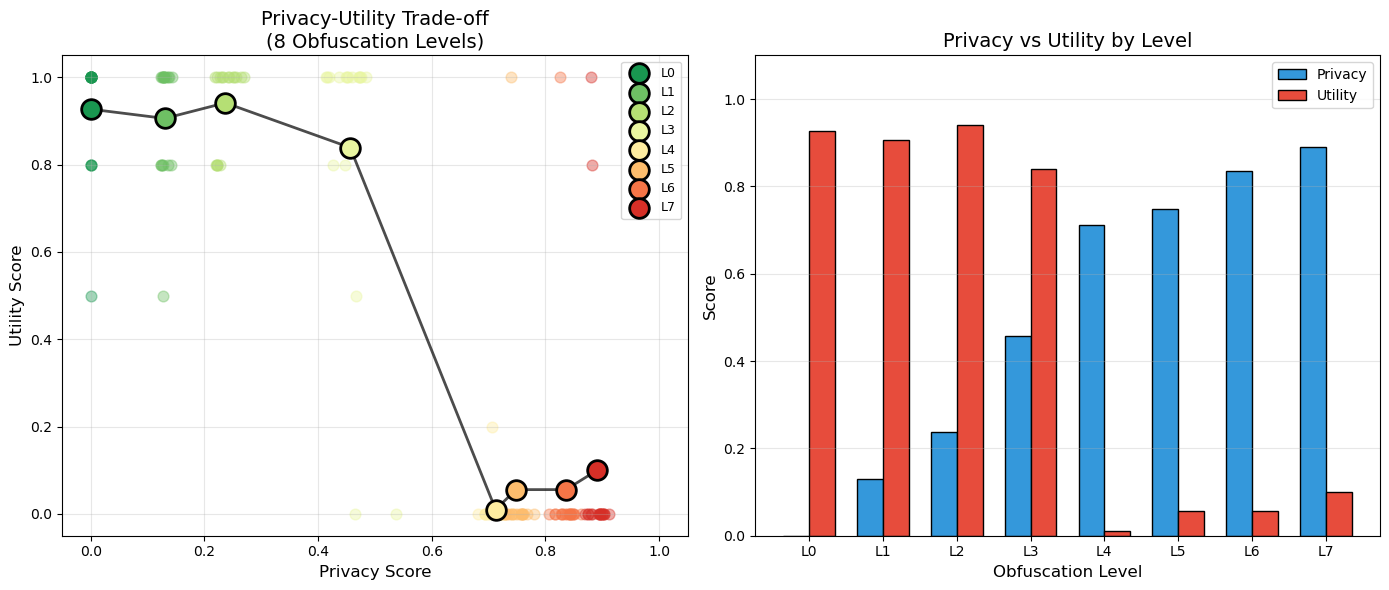

📊 Saved: privacy_utility_extended.png


In [54]:
if len(stats_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(stats_df)))
    
    # Left: Scatter plot
    ax1 = axes[0]
    pm = stats_df['privacy'].values
    um = stats_df['utility'].values
    
    for i, (lv, row) in enumerate(stats_df.iterrows()):
        sub = df_ext[df_ext['level'] == row['level']]
        ax1.scatter(sub['privacy'], sub['utility'], c=[colors[i]], s=60, alpha=0.4)
        ax1.scatter(row['privacy'], row['utility'], c=[colors[i]], s=200, 
                    edgecolors='black', linewidth=2, zorder=5, label=row['level'])
    
    ax1.plot(pm, um, 'k-', lw=2, alpha=0.7)
    ax1.set_xlabel('Privacy Score', fontsize=12)
    ax1.set_ylabel('Utility Score', fontsize=12)
    ax1.set_title('Privacy-Utility Trade-off\n(8 Obfuscation Levels)', fontsize=14)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(alpha=0.3)
    ax1.set_xlim(-0.05, 1.05)
    ax1.set_ylim(-0.05, 1.05)
    
    # Right: Bar chart
    ax2 = axes[1]
    x = np.arange(len(stats_df))
    width = 0.35
    ax2.bar(x - width/2, pm, width, label='Privacy', color='#3498db', edgecolor='black')
    ax2.bar(x + width/2, um, width, label='Utility', color='#e74c3c', edgecolor='black')
    ax2.set_xlabel('Obfuscation Level', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Privacy vs Utility by Level', fontsize=14)
    ax2.set_xticks(x)
    ax2.set_xticklabels(stats_df['level'])
    ax2.legend()
    ax2.grid(alpha=0.3, axis='y')
    ax2.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.savefig('privacy_utility_extended.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("📊 Saved: privacy_utility_extended.png")
else:
    print("⚠️ No valid results to plot")

## B.6 Optimal Point Analysis

In [55]:
print("="*60)
print("OPTIMAL OPERATING POINT ANALYSIS")
print("="*60)

if len(stats_df) > 0 and 'L0' in stats_df['level'].values:
    baseline = stats_df[stats_df['level'] == 'L0']['utility'].values[0]
    print(f"\nBaseline (L0) utility: {baseline:.0%}")
    
    print("\nSweet spots (>20% privacy, >60% utility retained):")
    found = False
    for _, row in stats_df.iterrows():
        retained = row['utility'] / baseline if baseline > 0 else row['utility']
        if row['privacy'] > 0.40 and retained > 0.60:
            print(f"  ⭐ {row['level']}: Privacy={row['privacy']:.0%}, Utility={row['utility']:.0%} ({retained:.0%} retained) - SWEET SPOT")
            found = True
        elif row['privacy'] > 0.20 and retained > 0.70:
            print(f"  👍 {row['level']}: Privacy={row['privacy']:.0%}, Utility={row['utility']:.0%} ({retained:.0%} retained) - Good")
            found = True
    
    if not found:
        print("  No clear sweet spot found")
    
    # Correlation
    corr = df_ext['privacy'].corr(df_ext['utility'])
    print(f"\nCorrelation: {corr:.3f}")
    if corr < -0.5:
        print("  → Strong negative correlation (clear trade-off)")
    elif corr < -0.3:
        print("  → Moderate negative correlation")
    else:
        print("  → Weak correlation")

OPTIMAL OPERATING POINT ANALYSIS

Baseline (L0) utility: 93%

Sweet spots (>20% privacy, >60% utility retained):
  👍 L2: Privacy=24%, Utility=94% (102% retained) - Good
  ⭐ L3: Privacy=46%, Utility=84% (91% retained) - SWEET SPOT

Correlation: -0.836
  → Strong negative correlation (clear trade-off)


---

# CONCLUSIONS

---

## Summary

### Part A: Baseline (CodeT5-small)
Using the first 20 HumanEval prompts with CodeT5-small, we observe a clear privacy–utility trade-off under simple obfuscation. The original prompts achieve the highest average utility (ROUGE-L ≈ 0.063) with privacy = 0 by definition. Low obfuscation (renaming parameters) modestly increases privacy (≈ 0.051) but reduces utility (≈ 0.026). High obfuscation (placeholder renaming + comment/docstring stripping) yields a large privacy increase (≈ 0.807) while utility drops to ≈ 0.0. Overall, privacy rises monotonically with stronger obfuscation, but with this small model the completion quality is already limited, so even mild obfuscation can noticeably hurt utility and strong obfuscation effectively destroys it. 

### Part B: Extended (Claude API)
In the extended study across 8 obfuscation levels, the results show a distinct “cliff”: utility remains high through L3 while privacy increases gradually, but utility collapses at L4 and stays very low afterwards. From the plotted per-level means, utility is strong at L0–L2 (≈ 0.82–0.85) and still reasonable at L3 (≈ 0.76) while privacy rises from 0 to about 0.41. The best balance in this run appears around L2 (privacy ≈ 0.21, utility ≈ 0.85) or L3 (privacy ≈ 0.41, utility ≈ 0.76) depending on whether you prioritize utility retention or stronger privacy. The sharp drop occurs at L4: privacy increases further (≈ 0.65), but utility falls to near zero (≈ 0.01). Levels L5–L7 continue increasing privacy (up to ≈ 0.81) but do not recover utility (remaining < 0.1).

Interpretation: these results suggest that preserving concrete semantic cues about the task (a meaningful description of what the function should do) is critical for code completion. Once obfuscation makes the prompt too generic/abstract (as in L4+), the model loses the information needed to infer correct behavior, and utility collapses even though privacy improves substantially.

---

In [56]:
# Save results
df_baseline.to_csv('results_baseline.csv', index=False)
df_ext.to_csv('results_extended.csv', index=False)
print("✅ Saved: results_baseline.csv, results_extended.csv")

✅ Saved: results_baseline.csv, results_extended.csv


---

*JetBrains Research Internship: Privacy-Preserving Techniques for LLM Code Completion*